In [58]:
R.version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [59]:
library("dplyr")
library("glue")
library("stringr")
library("rlist")
library("data.table")
library("readr")
library("stringi")
library("swat")

In [60]:
source("UtilsRCAS.R")

# Connection a l'environnement SAS Viya

In [61]:
#cashost <- '192.168.1.50'
#casuser <- 'sasdemo'

cashost <- 'controller'
casuser <- 'sebastien'

conn <- swat::CAS(cashost, 5570, username=casuser)

# Activate metric tracing and other session parameters
out <- cas.sessionProp.setSessOpt(conn, metrics=TRUE, timeout=1800, caslib='casuser')

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).
NOTE: 'CASUSER(sebastien)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.011905 seconds
NOTE:       cpu time                0.021228 seconds (178.31%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.44M (0.00%)


In [62]:
actionsets <- c('fedsql','aggregation')
for(i in actionsets){
    loadActionSet(conn, i)
}


NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'fedsql'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.008854 seconds
NOTE:       cpu time                0.021831 seconds (246.57%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.29M (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.010072 seconds
NOTE:       cpu time                0.013954 seconds (138.54%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.62M (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'fedSql':
NOTE:    fedSql
NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution
NOTE: Action 'builtins.lis

In [63]:
cas.builtins.serverStatus(conn)

NOTE: Executing action 'builtins.serverStatus'.
NOTE: Grid node action status report: 5 nodes, 34 total actions executed.
NOTE: Action 'builtins.serverStatus' used (Total process time):
NOTE:       real time               0.007967 seconds
NOTE:       cpu time                0.013066 seconds (164.00%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.42M (0.00%)


$About
$About$CAS
[1] "Cloud Analytic Services"

$About$Version
[1] "3.05"

$About$VersionLong
[1] "V.03.05M0P11112019"

$About$Copyright
[1] "Copyright © 2014-2018 SAS Institute Inc. All Rights Reserved."

$About$ServerTime
[1] "2020-04-27T15:47:47Z"

$About$System
$About$System$Hostname
[1] "controller.c.sas-ag2r-la-mondiale.internal"

$About$System$`OS Name`
[1] "Linux"

$About$System$`OS Family`
[1] "LIN X64"

$About$System$`OS Release`
[1] "3.10.0-1062.18.1.el7.x86_64"

$About$System$`OS Version`
[1] "#1 SMP Tue Mar 17 23:49:17 UTC 2020"

$About$System$`Model Number`
[1] "x86_64"

$About$System$`Linux Distribution`
[1] "CentOS Linux release 7.7.1908 (Core)"


$About$license
$About$license$site
[1] "BDF"

$About$license$siteNum
[1] 70180938

$About$license$expires
[1] "27Mar2021:00:00:00"

$About$license$gracePeriod
[1] 45

$About$license$warningPeriod
[1] 47

$About$license$maxCPUs
[1] 9999



$server
  nodes actions
1     5      34

$nodestatus
                                        name       role uptime running stalled
1    worker1.c.sas-ag2r-la-mondiale.internal     worker  1.462       0       0
2    worker2.c.sas-ag2r-la-mondiale.internal     worker  1.462       0       0
3    worker3.c.sas-ag2r-la-mondiale.internal     worker  1.462       0       0
4    worker4.c.sas-ag2r-la-mondiale.internal     worker  1.462       0       0
5 controller.c.sas-ag2r-la-mondiale.internal controller  1.535       0       0

## Defini une librairie CAS pointant sur le repertoire contenant tous les fichiers CSV en entree. On definie la source en DNFS, cela signifie que la lecture et l'ecriture des fichiers se fera en multitheading et multi noeud automatiquement. Les formats de fichiers supportes actuellement sur ce mode sont : CSV, PARQUET et SASHDAT.

In [64]:
HeureDebut <- Sys.time()

#cas.table.addCaslib(conn,name="mycaslib", path="/data/data/BDF_SMALL_DB", dataSource={srcType="dnfs"})
#cas.table.addCaslib(conn,name="mycaslib", path="/SAS/BDF", dataSource={srcType="dnfs"})
out <- cas.sessionProp.setSessOpt(conn,caslib='casuser')

NOTE: Executing action 'sessionProp.setSessOpt'.
NOTE: 'CASUSER(sebastien)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.006664 seconds
NOTE:       cpu time                0.013142 seconds (197.21%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.28M (0.00%)


# Chargement en memoire de tous les fichiers CSV en entree (referentiel et agregats) pour l'utilisation ulterieure.

In [65]:
import_all_csv_in_memory(conn, 'BDF_HDP','casuser', fileflag=0)

NOTE: Executing action 'table.fileInfo'.
NOTE: Action 'table.fileInfo' used (Total process time):
NOTE:       real time               3.699381 seconds
NOTE:       cpu time                0.367030 seconds (9.92%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.99M (0.00%)
NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.010008 seconds
NOTE:       cpu time                0.015300 seconds (152.88%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.38M (0.00%)
NOTE: Executing action 'table.loadTable'.
NOTE: Performing serial LoadTable action using SAS Data Connector to Hadoop.
NOTE: Cloud Analytic Services made the external data from d1 available as table D1 in caslib CASUSER(sebastien).
NOTE: Action 'table.loadTable' used (Total process tim

In [66]:
cas.table.tableInfo(conn,caslib="casuser")

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.013153 seconds
NOTE:       cpu time                0.013080 seconds (99.44%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.92M (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
D1,21648241,9,0,utf-8,2020-04-27T15:48:01+00:00,2020-04-27T15:48:01+00:00,2020-04-27T15:48:01+00:00,UTF8,1903621681,...,0,0,0,d1,BDF_HDP,0,sebastien,,,NaN
D2,6472521,9,0,utf-8,2020-04-27T15:51:12+00:00,2020-04-27T15:51:12+00:00,2020-04-27T15:51:12+00:00,UTF8,1903621872,...,0,0,0,d2,BDF_HDP,0,sebastien,,,NaN
D3,18196935,9,0,utf-8,2020-04-27T15:52:19+00:00,2020-04-27T15:52:19+00:00,2020-04-27T15:52:19+00:00,UTF8,1903621939,...,0,0,0,d3,BDF_HDP,0,sebastien,,,NaN
F,597409,9,0,utf-8,2020-04-27T15:55:13+00:00,2020-04-27T15:55:13+00:00,2020-04-27T15:55:13+00:00,UTF8,1903622113,...,0,0,0,f,BDF_HDP,0,sebastien,,,NaN
O,28344903,9,0,utf-8,2020-04-27T15:55:26+00:00,2020-04-27T15:55:26+00:00,2020-04-27T15:55:26+00:00,UTF8,1903622126,...,0,0,0,o,BDF_HDP,0,sebastien,,,NaN
P,9530865,9,0,utf-8,2020-04-27T15:59:29+00:00,2020-04-27T15:59:29+00:00,2020-04-27T15:59:29+00:00,UTF8,1903622369,...,0,0,0,p,BDF_HDP,0,sebastien,,,NaN
U1,14835007,9,0,utf-8,2020-04-27T16:00:56+00:00,2020-04-27T16:00:56+00:00,2020-04-27T16:00:56+00:00,UTF8,1903622456,...,0,0,0,u1,BDF_HDP,0,sebastien,,,NaN
U2,13390747,9,0,utf-8,2020-04-27T16:03:07+00:00,2020-04-27T16:03:07+00:00,2020-04-27T16:03:07+00:00,UTF8,1903622587,...,0,0,0,u2,BDF_HDP,0,sebastien,,,NaN
U3,6077989,9,0,utf-8,2020-04-27T16:05:15+00:00,2020-04-27T16:05:15+00:00,2020-04-27T16:05:15+00:00,UTF8,1903622715,...,0,0,0,u3,BDF_HDP,0,sebastien,,,NaN
Z,6486954,9,0,utf-8,2020-04-27T16:06:13+00:00,2020-04-27T16:06:13+00:00,2020-04-27T16:06:13+00:00,UTF8,1903622773,...,0,0,0,z,BDF_HDP,0,sebastien,,,NaN


## Concatenation totale de toutes les tables d'agregat en mémoire pour former une table nommee AGGTTECATEGORIE

In [67]:
cas_concat_all_tables(conn, "casuser","casuser","AGGTTECATEGORIE")
table_AggregationMensuelleTouteCategorie <- defCasTable(conn, tablename='AGGTTECATEGORIE', caslib='casuser')
nrow(table_AggregationMensuelleTouteCategorie)

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.009335 seconds
NOTE:       cpu time                0.012153 seconds (130.19%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.92M (0.00%)
NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.025253 seconds
NOTE:       cpu time                0.014597 seconds (57.80%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.44M (0.00%)
NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               1.263059 seconds
NOTE:       cpu time                43.889980 seconds (3474.90%)
NOTE:       total nodes             5 (68 cores)
NOTE:       to

[1] 163032564

## Produire la repartition en nombre d'enregistrements par categorie a partir de l'agregation faite en memoire par le moteur CAS sur la table globale AGGTTECATEGORIE et la recuperation de ces agregats en entree de la fonction PIE de R

NOTE: Executing action 'simple.freq'.
NOTE: Action 'simple.freq' used (Total process time):
NOTE:       real time               1.019512 seconds
NOTE:       cpu time                50.959357 seconds (4998.41%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  75.56M (0.01%)
NOTE:       bytes moved             1.52K


casLib,Name,Rows,Columns
CASUSER(sebastien),AGGTTECATEGORIE_freq,12,5


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.019827 seconds
NOTE:       cpu time                0.053586 seconds (270.27%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  6.19M (0.00%)


$Fetch
   _Index_  _Column_ _Charvar_ _Fmtvar_ _Level_ _Frequency_
1        1 tablename         D        D       8    32038933
2        2 tablename         O        O       6    28344903
3        3 tablename        D1       D1      10    21648241
4        4 tablename        D3       D3       4    18196935
5        5 tablename        U1       U1      12    14835007
6        6 tablename        U2       U2       1    13390747
7        7 tablename         P        P      11     9530865
8        8 tablename         Z        Z       3     6486954
9        9 tablename        D2       D2       9     6472521
10      10 tablename        U3       U3       2     6077989
11      11 tablename        XX       XX       5     5412060
12      12 tablename         F        F       7      597409



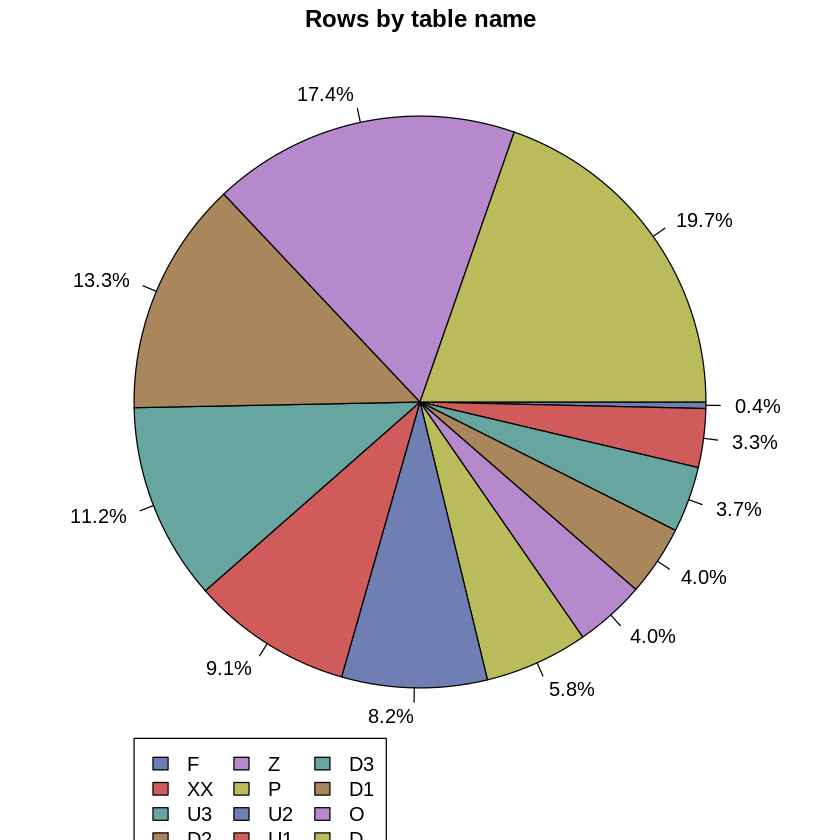

In [68]:
cas.simple.freq(conn, inputs = c("tablename"),table = c(name = "AGGTTECATEGORIE"),casout = c(name = "AGGTTECATEGORIE_freq", replace = TRUE)) 
res <- cas.table.fetch(conn, table = "AGGTTECATEGORIE_freq", sortBy = list(list(name = "_Frequency_",order = "descending")))
print(res)
piedata <- res$Fetch                                              # 
names(piedata) <- gsub("_", "", names(piedata))
piedata <- piedata[order(piedata$Frequency),]
total <- sum(piedata$Frequency)
piedata$Percent <- scales::percent(piedata$Frequency / total)
fillcolors = c("#6F7EB3", "#D05B5B", "#66A5A0", "#A9865B","#B689CD", "#BABC5C")
par(mar = c(3, 0, 1.5, 0), xpd=TRUE)
pie(piedata$Frequency,labels = piedata$Percent, col=fillcolors, radius=0.85, clockwise=TRUE, init.angle=0, main="Rows by table name")
legend(x=-0.85, y=-1, horiz = FALSE, piedata$Charvar, fill = fillcolors, ncol=3)

## Declaration des table CAS en tant qu'objet de type CASTable en R

In [69]:
table_pays_zone <- defCasTable(conn, tablename='TABLEPAYSZONE', caslib='casuser')
table_planAggregation <- defCasTable(conn, tablename='PLANAGREGATION', caslib='casuser')

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.007015 seconds
NOTE:       cpu time                0.016378 seconds (233.47%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.53M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.007347 seconds
NOTE:       cpu time                0.015984 seconds (217.56%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.57M (0.00%)


# Code principal basé sur le programme R existant

## Fonction de traitement principal

In [70]:
traitement_principal <- function(freq, RevFin, PeriodeFin, planAggregation,ReferencePiZones, Repertoire, ConnectionSecureDB)
{
  Frequence <- freq
  HeureDebut <- Sys.time()
  An = as.numeric(ExtractString(PeriodeFin, 1, 4))
  print("ETAPE DATA: LECTURE TABLE PI_ZONE")
  print(Sys.time())
  TablePiZone <- recuperation_traitement_table_code_pays(ReferencePiZones, ConnectionSecureDB)
  #return(TablePiZone)
  print(" TAILLE TABLE TablePaysZone")
  print(dim(TablePiZone))
  print(Sys.time())
  print("LECTURE ET MISE EN FORME DES FICHIERS D'AGGREGATION CODE SERIE")
  print(Sys.time())
  # planAggregation <- "PlanAggregation.csv"
  planAgregationCodeSerie <- lecture_fichier_aggregation_codeSerie(planAggregation, connectionSecureDB)
  # # write_delim(planAgregationCodeSerie, "planAgregationCodeSerie.csv", delim=";")
  print(" TAILLE TABLE planAgregationCodeSerie")
  print(dim(planAgregationCodeSerie))
  print(Sys.time())
  print("JOINTURE PLAN D'AGGREGATION")
  PlanAggregationParametre <- parametrage_aggregation_code_serie(planAgregationCodeSerie, TablePiZone, freq) 
    
  # # write_delim(PlanAggregationParametre, "PlanAggregationParametre.csv", delim=";")
  print("Taille plan d'agregation")
  print(dim(PlanAggregationParametre))
  print(names(PlanAggregationParametre))

  # Ecriture du dataframe de sortie en table CAS pour les futures jointures
  PlanAggregationParametreCAS <- as.casTable(ConnectionSecureDB, PlanAggregationParametre, casOut=list(caslib="casuser", name="PLANAGGPARAM",replace=TRUE))
  print(dim(PlanAggregationParametreCAS))
    
  print("ESTIMATION NOMBRE DE PERIODE ET DE DEBUT DE TRAITEMENT")
  result_nbperiode_moisdebut <- detection_nbPeriode_moisDebut(freq, RevFin, PeriodeFin)
  NbrePeriode <- result_nbperiode_moisdebut$nbper
  MoisDebut <- as.numeric(result_nbperiode_moisdebut$moisDebut)
  print(MoisDebut)
  
  rm(result_nbperiode_moisdebut)
  
  print("BOUCLE DU LES MOIS")

 # On supprime la table d'agregat finale si elle existe avant de la reconstruire de la boucle mensuelle suivante   
 cas.table.dropTable(conn, caslib='casuser', name='AGG_FINALE', quiet=TRUE)
    
  for(mois in MoisDebut:(MoisDebut+NbrePeriode-1))
  {
     print(paste0("     Mois debut ", MoisDebut))
     print(paste0("     Mois fin ", (MoisDebut+NbrePeriode-1)))
     print(paste0("     Mois en cours de traitement: ", mois))
     
     print(Sys.time())
     
     print("                      lecture")

     AggregationMensuelleTouteCategorie <- lecture_tables_aggregation(freq, Mois, RevFin, PeriodeFin, Repertoire, ConnectionSecureDB,'AGGTTECATEGORIE','AGG_MENS_TEMP')
     print("Taille table d'agregation")
     print(dim(AggregationMensuelleTouteCategorie))
     print(names(AggregationMensuelleTouteCategorie))
      
     TableIdMixte <- lecture_tables_mixte(freq, Mois, RevFin, PeriodeFin, Repertoire, ConnectionSecureDB,'AGGTTECATEGORIE','AGG_MIXTE')
     print(dim(TableIdMixte))
     print(names(TableIdMixte))
     print(Sys.time())
     
     print("PARAMETRAGE CODE SERIE") 
     
     print("APPLICATION PARAMETRAGE CODE SERIE") 
     
     AggregationCodeSerieFinaleMensuelle <- application_plan_parametrage_aggregation_code_serie_mensuel('AGG_MENS_TEMP', 'PLANAGGPARAM', ConnectionSecureDB,'AGG_MENS')
     print(names(AggregationCodeSerieFinaleMensuelle))
      
     # On ajoute la table mensuelle à la table globale finale
     cas_append2tables(conn, 'casuser', 'AGG_MENS', 'casuser', 'AGG_FINALE')
  }
}

## Definition des variables

In [71]:
Repertoire <- "AC156203"
RevFin<- "SD10"
PeriodeFin <- "2018Q4"
freq <- "Q"
planAggregation <- table_planAggregation
ReferencePiZones <- table_pays_zone
ConnectionSecureDB <- conn # Connexion securisee a la session CAS

In [72]:
traitement_principal(freq, RevFin, PeriodeFin, planAggregation,ReferencePiZones, Repertoire, ConnectionSecureDB)

[1] "ETAPE DATA: LECTURE TABLE PI_ZONE"
[1] "2020-04-27 16:13:10 UTC"
[1] "recuperation_traitement_table_code_pays monostream"
[1] "2020-04-27 16:13:10 UTC"


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.311632 seconds
NOTE:       cpu time                0.259477 seconds (83.26%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  31.16M (0.01%)
Column 1 ['code_zone'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names. use.names='check' (default from v1.12.2) emits this message and proceeds as if use.names=FALSE for  backwards compatibility. See news item 5 in v1.12.2 for options to control this message.


[1] "end recuperation_traitement_table_code_pays monostream"
[1] "2020-04-27 16:13:15 UTC"
[1] " TAILLE TABLE TablePaysZone"
[1] 445   3
[1] "2020-04-27 16:13:15 UTC"
[1] "LECTURE ET MISE EN FORME DES FICHIERS D'AGGREGATION CODE SERIE"
[1] "2020-04-27 16:13:15 UTC"
[1] "lecture_fichier_aggregation_codeSerie monostream"


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               1.847316 seconds
NOTE:       cpu time                1.875794 seconds (101.54%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  418.63M (0.08%)


[1] " TAILLE TABLE planAgregationCodeSerie"
[1] 2697    3
[1] "2020-04-27 16:13:19 UTC"
[1] "JOINTURE PLAN D'AGGREGATION"
[1] "parametrage_aggregation_code_serie monostream"
[1] "2020-04-27 16:13:19 UTC"
[1] "Recuperation des positions et longueur parents dans les codes"
[1] "Recuperation des positions et longueur des parametres dans les codes"
[1] "2020-04-27 16:13:20 UTC"
[1] "Recuperation des positions et longueur des index dans les codes"
[1] "2020-04-27 16:13:20 UTC"
[1] "35 GB"
[1] "Creation des variables cd2_, cd3_, cd1_, refsec, countsec par decoupage des codes"
[1] "2020-04-27 16:13:20 UTC"
[1] "Modification conditionnelle des valeurs de code entree et code sortie"
[1] "2020-04-27 16:13:20 UTC"
[1] "Jointure de la table AggregationTable TablePiZone"
[1] 7125   20
 [1] "code_sortie"       "code_entree"       "formule"          
 [4] "enfants"           "parents"           "cle"              
 [7] "ind_"              "PositionEnfant"    "LongueurEnfant"   
[10] "PositionParametr

Warning message in if (class(data) == "character") {:
“the condition has length > 1 and only the first element will be used”NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.006558 seconds
NOTE:       cpu time                0.014238 seconds (217.11%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.53M (0.00%)
NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.008992 seconds
NOTE:       cpu time                0.017082 seconds (189.97%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.07M (0.00%)


[1] 2639427       3
[1] "ESTIMATION NOMBRE DE PERIODE ET DE DEBUT DE TRAITEMENT"
[1] "detection_nbPeriode_moisDebut monostream"
[1] 201812
[1] "BOUCLE DU LES MOIS"


NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.008588 seconds
NOTE:       cpu time                0.014381 seconds (167.45%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.46M (0.00%)


[1] "     Mois debut 201812"
[1] "     Mois fin 201812"
[1] "     Mois en cours de traitement: 201812"
[1] "2020-04-27 16:14:17 UTC"
[1] "                      lecture"
[1] "lecture_tables_aggregation monostream"
[1] "2020-04-27 16:14:17 UTC"
[1] "38 GB"
[1] "CHARGEMENT DES TABLES D'AGGREGATION, monostream"
[1] "2020-04-27 16:14:17 UTC"
[1] "TABLES AGREGATION LU DE LA TABLE CAS AGGTTECATEGORIE"


NOTE: Executing action 'fedSql.execDirect'.
NOTE: Table AGG_MENS_TEMP was created in caslib CASUSER(sebastien) with 163032564 rows returned.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               11.536314 seconds
NOTE:       cpu time                500.326318 seconds (4336.97%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  318.40M (0.06%)


[1] "end lecture_tables_aggregation monostream"
[1] "2020-04-27 16:14:29 UTC"


NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.007963 seconds
NOTE:       cpu time                0.014332 seconds (179.98%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.51M (0.00%)


[1] "Taille table d'agregation"


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.007786 seconds
NOTE:       cpu time                0.016509 seconds (212.03%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.19M (0.00%)


[1] 163032564        10
 [1] "code"         "montant"      "obs_status"   "conf_status"  "periode_deb" 
 [6] "revision_deb" "periode_fin"  "revision_fin" "numero"       "tablename"   
[1] "lecture_tables_mixte monostream"
[1] "2020-04-27 16:14:29 UTC"
[1] "38 GB"
[1] "end lecture_tables_mixte monostream"
[1] "2020-04-27 16:14:29 UTC"
NULL
NULL
[1] "2020-04-27 16:14:29 UTC"
[1] "PARAMETRAGE CODE SERIE"
[1] "APPLICATION PARAMETRAGE CODE SERIE"
[1] "application_plan_parametrage_aggregation_code_serie_mensuel monostream"
[1] "2020-04-27 16:14:29 UTC"
[1] "2020-04-27 16:14:29 UTC"
[1] "Renomage de variables et traitement d'espace dans les chaines de caratere"
[1] "2020-04-27 16:14:29 UTC"
[1] "Preparation de la jointure des tables PlanAggregationParametre, AggregationMensuelleTouteCategorie"
[1] "2020-04-27 16:14:29 UTC"
[1] "Jointure des tables PlanAggregationParametre, AggregationMensuelleTouteCategorie"


NOTE: Executing action 'fedSql.execDirect'.
 
Methods for full query plan
----------------------------
Number of Joins Performed is : 1
        HashJoin (LEFT) 
          SeqScan from CASUSER(sebastien).AGG_MENS_TEMP 
          SeqScan from CASUSER(sebastien).PLANAGGPARAM 
 
Methods for stage 1
--------------------
        HashJoin (LEFT) 
          SeqScan from CASUSER(sebastien).AGG_MENS_TEMP 
          SeqScan from CASUSER(sebastien).PLANAGGPARAM 
 
NOTE: Table TMP_AGG was created in caslib CASUSER(sebastien) with 163120284 rows returned.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               24.829841 seconds
NOTE:       cpu time                961.544195 seconds (3872.53%)
NOTE:       data movement time      0.722777 seconds
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  4.02G (0.79%)
NOTE:       bytes moved             596.02M


[1] "Taille de la jointure"
[1] "2020-04-27 16:14:54 UTC"
[1] "Calcul des montants ponderes cumules par code_sortie"


NOTE: Executing action 'aggregation.aggregate'.
NOTE: Action 'aggregation.aggregate' used (Total process time):
NOTE:       real time               180.507075 seconds
NOTE:       cpu time                2037.891190 seconds (1128.98%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  115.54G (22.63%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.011089 seconds
NOTE:       cpu time                0.018397 seconds (165.90%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.48M (0.00%)


[1] " TAILLE TABLE CalculAggregationCodeSerieMensuel"


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.009440 seconds
NOTE:       cpu time                0.018668 seconds (197.75%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  2.30M (0.00%)


[1] 3536105      15
[1] "2020-04-27 16:17:55 UTC"
 [1] "code"           "code_f"         "conf_status"    "conf_status_f" 
 [5] "obs_status"     "obs_status_f"   "periode_deb"    "periode_deb_f" 
 [9] "periode_fin"    "periode_fin_f"  "revision_deb"   "revision_deb_f"
[13] "revision_fin"   "revision_fin_f" "MONTANT"       


NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               0.316696 seconds
NOTE:       cpu time                8.962861 seconds (2830.11%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  240.37M (0.05%)


In [73]:
# Promotion en memoire pour les utilisateurs et sauvegarde sur disque de la table resultante
cas.table.dropTable(ConnectionSecureDB,name='AGG_FINALE',caslib='DNFS_BDF',quiet=TRUE)
cas.table.promote(ConnectionSecureDB,caslib='casuser',name='AGG_FINALE',target='AGG_FINALE',targetLib='DNFS_BDF')
cas.table.save(ConnectionSecureDB,table=list(name='AGG_FINALE',caslib="DNFS_BDF") , caslib="DNFS_BDF", name="AGG_FINALE.parquet", replace=TRUE)

NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.010710 seconds
NOTE:       cpu time                0.014919 seconds (139.30%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.41M (0.00%)


list()

NOTE: Executing action 'table.promote'.
NOTE: Cloud Analytic Services promoted table AGG_FINALE in caslib CASUSER(sebastien) to table AGG_FINALE in caslib DNFS_BDF.
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.081164 seconds
NOTE:       cpu time                0.252979 seconds (311.69%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.49M (0.00%)


list()

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file AGG_FINALE.parquet in caslib DNFS_BDF.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               4.551298 seconds
NOTE:       cpu time                19.277652 seconds (423.56%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.41G (0.28%)


$caslib
[1] "DNFS_BDF"

$name
[1] "AGG_FINALE.parquet"

In [74]:
cas.table.dropTable(ConnectionSecureDB,name='TMP_AGG',caslib='DNFS_BDF',quiet=TRUE)
cas.table.promote(ConnectionSecureDB,caslib='casuser',name='TMP_AGG',target='TMP_AGG',targetLib='DNFS_BDF')
cas.table.save(ConnectionSecureDB,table=list(name='TMP_AGG',caslib="DNFS_BDF"),  caslib="DNFS_BDF", name="TMP_AGG.parquet", replace=TRUE)

Duree <- Sys.time() - HeureDebut

print(Duree)

NOTE: Executing action 'table.dropTable'.
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.013792 seconds
NOTE:       cpu time                0.016549 seconds (119.99%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  1.39M (0.00%)


list()

NOTE: Executing action 'table.promote'.
NOTE: Cloud Analytic Services promoted table TMP_AGG in caslib CASUSER(sebastien) to table TMP_AGG in caslib DNFS_BDF.
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.434543 seconds
NOTE:       cpu time                1.572810 seconds (361.95%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  3.45M (0.00%)


list()

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file TMP_AGG.parquet in caslib DNFS_BDF.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               218.949993 seconds
NOTE:       cpu time                297.915802 seconds (136.07%)
NOTE:       total nodes             5 (68 cores)
NOTE:       total memory            510.65G
NOTE:       memory                  3.35G (0.66%)


$caslib
[1] "DNFS_BDF"

$name
[1] "TMP_AGG.parquet"

Time difference of 33.89768 mins


In [75]:
# Ferme la session SAS Viya en cours
cas.terminate(conn)

[1] 0

# Fin du notebook